In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint
from sklearn.linear_model import Ridge
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


In [4]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[499]

((500, 1), (500,), ('flu',), ('symptoms of kidney infection',))

In [5]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,500):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [6]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [7]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  212


In [8]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def ridge(a,train_X,train_y,test_X,test_y):
    alpha=a
    ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
  
    ri.fit(train_X,train_y)

    y_pred1 = ri.predict(test_X)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr

# Generalise the function for convinient tuning

def eNet(a,l,train_X,train_y,test_X,test_y):
    alpha = a
    l1_ratio = l
    enet = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
    enet.fit(train_X,train_y)
    print('Nonzero weights: %d from %d' % (len(np.nonzero(enet.coef_)[0]), len(enet.coef_)))
    y_pred1 = enet.predict(test_X)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    
    


# scaling and modeling
scaler = MinMaxScaler()
train1_X0_scaled = scaler.fit_transform(train1_X0)
test1_X0_scaled = scaler.transform(test1_x0)

train1_X1_scaled = scaler.fit_transform(train1_X1)
test1_X1_scaled = scaler.transform(test1_x1)

train1_X2_scaled = scaler.fit_transform(train1_X2)
test1_X2_scaled = scaler.transform(test1_x2)

train1_X3_scaled = scaler.fit_transform(train1_X3)
test1_X3_scaled = scaler.transform(test1_x3)


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [9]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 212) (400, 212)


((4018, 212), (4018, 1))

In [12]:

para = np.arange(2340000, 2400000, 100)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')
        

alpha: 2340000
Best RMSE is updated! 
The mean absolute error is:  24.50768934214041
The root mean squared error is:  47.554453038753316
The correlation is:  0.8552103435095919
----------------------------------------
alpha: 2340100
Best RMSE is updated! 
The mean absolute error is:  24.507702538494637
The root mean squared error is:  47.55445295176054
The correlation is:  0.8552112129578018
----------------------------------------
alpha: 2340200
Best RMSE is updated! 
The mean absolute error is:  24.507715734666217
The root mean squared error is:  47.554452865728756
The correlation is:  0.8552120823389149
----------------------------------------
alpha: 2340300
Best RMSE is updated! 
The mean absolute error is:  24.50772893065513
The root mean squared error is:  47.55445278065788
The correlation is:  0.8552129516529363
----------------------------------------
alpha: 2340400
Best RMSE is updated! 
The mean absolute error is:  24.507742126460375
The root mean squared error is:  47.554452

Best RMSE is updated! 
The mean absolute error is:  24.508137915618903
The root mean squared error is:  47.55445061909728
The correlation is:  0.8552398671480956
----------------------------------------
alpha: 2343500
Best RMSE is updated! 
The mean absolute error is:  24.508151105755875
The root mean squared error is:  47.55445056468733
The correlation is:  0.8552407343188244
----------------------------------------
alpha: 2343600
Best RMSE is updated! 
The mean absolute error is:  24.508164295708447
The root mean squared error is:  47.554450511229845
The correlation is:  0.8552416014226965
----------------------------------------
alpha: 2343700
Best RMSE is updated! 
The mean absolute error is:  24.508177485479596
The root mean squared error is:  47.554450458731516
The correlation is:  0.8552424684596976
----------------------------------------
alpha: 2343800
Best RMSE is updated! 
The mean absolute error is:  24.508190675066494
The root mean squared error is:  47.55445040718569
The 

Best RMSE is updated! 
The mean absolute error is:  24.50855990915422
The root mean squared error is:  47.554449351147454
The correlation is:  0.8552675834797608
----------------------------------------
alpha: 2346700
Best RMSE is updated! 
The mean absolute error is:  24.508573093428872
The root mean squared error is:  47.554449327238444
The correlation is:  0.8552684485141537
----------------------------------------
alpha: 2346800
Best RMSE is updated! 
The mean absolute error is:  24.50858627752104
The root mean squared error is:  47.55444930428205
The correlation is:  0.8552693134818896
----------------------------------------
alpha: 2346900
Best RMSE is updated! 
The mean absolute error is:  24.50859946142874
The root mean squared error is:  47.554449282273524
The correlation is:  0.8552701783829925
----------------------------------------
alpha: 2347000
Best RMSE is updated! 
The mean absolute error is:  24.50861264515285
The root mean squared error is:  47.55444926121488
The cor

alpha: 2357500
alpha: 2357600
alpha: 2357700
alpha: 2357800
alpha: 2357900
alpha: 2358000
alpha: 2358100
alpha: 2358200
alpha: 2358300
alpha: 2358400
alpha: 2358500
alpha: 2358600
alpha: 2358700
alpha: 2358800
alpha: 2358900
alpha: 2359000
alpha: 2359100
alpha: 2359200
alpha: 2359300
alpha: 2359400
alpha: 2359500
alpha: 2359600
alpha: 2359700
alpha: 2359800
alpha: 2359900
alpha: 2360000
alpha: 2360100
alpha: 2360200
alpha: 2360300
alpha: 2360400
alpha: 2360500
alpha: 2360600
alpha: 2360700
alpha: 2360800
alpha: 2360900
alpha: 2361000
alpha: 2361100
alpha: 2361200
alpha: 2361300
alpha: 2361400
alpha: 2361500
alpha: 2361600
alpha: 2361700
alpha: 2361800
alpha: 2361900
alpha: 2362000
alpha: 2362100
alpha: 2362200
alpha: 2362300
alpha: 2362400
alpha: 2362500
alpha: 2362600
alpha: 2362700
alpha: 2362800
alpha: 2362900
alpha: 2363000
alpha: 2363100
alpha: 2363200
alpha: 2363300
alpha: 2363400
alpha: 2363500
alpha: 2363600
alpha: 2363700
alpha: 2363800
alpha: 2363900
alpha: 2364000
alpha: 236

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [10]:
para =[2349200,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train3_X,train3_y,test1_X1,test1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 2349200
Best RMSE is updated! 
The mean absolute error is:  2.818264346735495
The root mean squared error is:  3.401654746051495
The correlation is:  0.919582871418051
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.691357664869584
The root mean squared error is:  3.379886907837204
The correlation is:  0.9107676241156437
----------------------------------------


In [11]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [11]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train3_X,train3_y,test1_X1,test1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 11  L1-ratio: 0.3
Nonzero weights: 77 from 212
Best RMSE is updated! 
The mean absolute error is:  2.702528763530121
The root mean squared error is:  3.293105297614681
The correlation is:  0.9144646439341871
----------------------------------------


In [13]:
alpha=2349200 
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1_ri = ri.predict(test1_X1)

alpha=0
ls = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ls.fit(train3_X,train3_y)

y_pred1_ls = ls.predict(test1_X1)


enet = ElasticNet(alpha=11, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train3_X,train3_y)

y_pred1_en = enet.predict(test1_X1)

<Figure size 432x288 with 0 Axes>

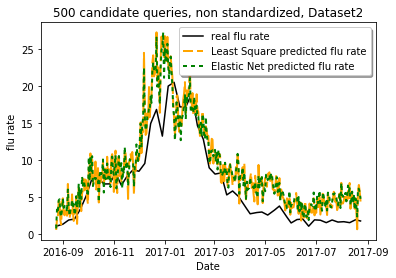

In [14]:
f= plt.figure()
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate',color='black')
#ax.plot(date[4018:],y_pred1,label='Ridge predicted flu rate')
ax.plot(date[4018:],y_pred1_ls,label='Least Square predicted flu rate',dashes=[5,2,20,2], linewidth=2,color='orange')
ax.plot(date[4018:],y_pred1_en,label='Elastic Net predicted flu rate',dashes=[2,2], linewidth=2,color='green')
# Now add the legend with some customizations.

legend = ax.legend(loc='upper right', shadow=True)
plt.title("500 candidate queries, non standardized, Dataset2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("500nostandard_test2.pdf", bbox_inches='tight')

plt.show()


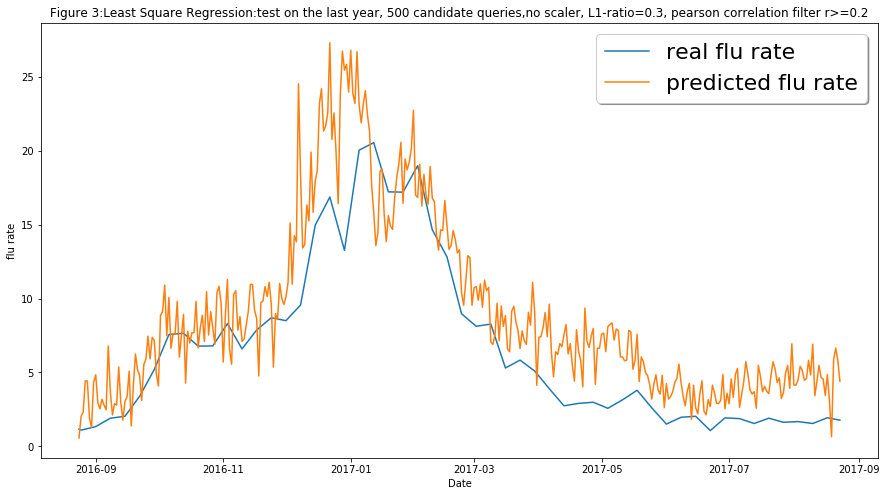

In [36]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True,prop={'size':22})
plt.title("Figure 3:Least Square Regression:test on the last year, 500 candidate queries,no scaler, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [15]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[499]

((500, 1), (500,), ('flu',), ('symptoms of kidney infection',))

In [16]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [17]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  222


# scaling and modeling
scaler = MinMaxScaler()
train2_X0_scaled = scaler.fit_transform(train2_X0)
test2_X0_scaled = scaler.transform(test2_X0)

train2_X1_scaled = scaler.fit_transform(train2_X1)
test2_X1_scaled = scaler.transform(test2_X1)

train2_X2_scaled = scaler.fit_transform(train2_X2)
test2_X2_scaled = scaler.transform(test2_X2)

train2_X3_scaled = scaler.fit_transform(train2_X3)
test2_X3_scaled = scaler.transform(test2_X3)


para = range(1,100)
para = np.arange(0.01, 10.0, 0.01)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

In [18]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 222) (360, 222)


((3653, 222), (3653, 1))

In [22]:

para =np.arange(0, 10000000, 10000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train2_X1,train2_y,val2_X1,val2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 0
Best RMSE is updated! 
The mean absolute error is:  5.250710339696028
The root mean squared error is:  12.120662062933187
The correlation is:  0.3484149072444635
----------------------------------------
alpha: 10000
Best RMSE is updated! 
The mean absolute error is:  5.189276058431394
The root mean squared error is:  11.908963567884644
The correlation is:  0.35312991593636595
----------------------------------------
alpha: 20000
Best RMSE is updated! 
The mean absolute error is:  5.13616316645369
The root mean squared error is:  11.72386584370174
The correlation is:  0.35734568268089334
----------------------------------------
alpha: 30000
Best RMSE is updated! 
The mean absolute error is:  5.0891995899644815
The root mean squared error is:  11.559678212324842
The correlation is:  0.36115872860171255
----------------------------------------
alpha: 40000
Best RMSE is updated! 
The mean absolute error is:  5.047239978874773
The root mean squared error is:  11.412294818792176
The

Best RMSE is updated! 
The mean absolute error is:  4.357362286491674
The root mean squared error is:  8.76992094151206
The correlation is:  0.4403050627043324
----------------------------------------
alpha: 550000
Best RMSE is updated! 
The mean absolute error is:  4.3511617904687085
The root mean squared error is:  8.742982141683482
The correlation is:  0.44128287126036264
----------------------------------------
alpha: 560000
Best RMSE is updated! 
The mean absolute error is:  4.345042821959543
The root mean squared error is:  8.71643184565065
The correlation is:  0.4422529390333266
----------------------------------------
alpha: 570000
Best RMSE is updated! 
The mean absolute error is:  4.339003143789641
The root mean squared error is:  8.690259677184926
The correlation is:  0.4432154611284691
----------------------------------------
alpha: 580000
Best RMSE is updated! 
The mean absolute error is:  4.333049165056717
The root mean squared error is:  8.664455732002617
The correlation

Best RMSE is updated! 
The mean absolute error is:  4.18785802120948
The root mean squared error is:  8.043507848047087
The correlation is:  0.46925708032806435
----------------------------------------
alpha: 880000
Best RMSE is updated! 
The mean absolute error is:  4.1835860219485985
The root mean squared error is:  8.025639022156136
The correlation is:  0.47004666530660383
----------------------------------------
alpha: 890000
Best RMSE is updated! 
The mean absolute error is:  4.179353277360053
The root mean squared error is:  8.007963215331273
The correlation is:  0.4708319385603746
----------------------------------------
alpha: 900000
Best RMSE is updated! 
The mean absolute error is:  4.175159123501064
The root mean squared error is:  7.990477183957644
The correlation is:  0.47161295250970625
----------------------------------------
alpha: 910000
Best RMSE is updated! 
The mean absolute error is:  4.171002914452698
The root mean squared error is:  7.973177770373635
The correlat

Best RMSE is updated! 
The mean absolute error is:  4.036483963725477
The root mean squared error is:  7.429451093787394
The correlation is:  0.49918183557219103
----------------------------------------
alpha: 1300000
Best RMSE is updated! 
The mean absolute error is:  4.033457605724165
The root mean squared error is:  7.417616737318525
The correlation is:  0.4998232955243505
----------------------------------------
alpha: 1310000
Best RMSE is updated! 
The mean absolute error is:  4.030452589373851
The root mean squared error is:  7.40588797084166
The correlation is:  0.5004618299343315
----------------------------------------
alpha: 1320000
Best RMSE is updated! 
The mean absolute error is:  4.02746865890976
The root mean squared error is:  7.394263500235172
The correlation is:  0.5010974593042542
----------------------------------------
alpha: 1330000
Best RMSE is updated! 
The mean absolute error is:  4.024505563275169
The root mean squared error is:  7.382742054559538
The correlat

Best RMSE is updated! 
The mean absolute error is:  3.902456336080139
The root mean squared error is:  6.90773592484851
The correlation is:  0.5305619126108215
----------------------------------------
alpha: 1850000
Best RMSE is updated! 
The mean absolute error is:  3.9006331734271598
The root mean squared error is:  6.9002475605631535
The correlation is:  0.5310661211072527
----------------------------------------
alpha: 1860000
Best RMSE is updated! 
The mean absolute error is:  3.8988202015627396
The root mean squared error is:  6.892817423375149
The correlation is:  0.5315681823166534
----------------------------------------
alpha: 1870000
Best RMSE is updated! 
The mean absolute error is:  3.89703022132812
The root mean squared error is:  6.885444957435811
The correlation is:  0.532068106034574
----------------------------------------
alpha: 1880000
Best RMSE is updated! 
The mean absolute error is:  3.8952532824538055
The root mean squared error is:  6.878129614167915
The correl

Best RMSE is updated! 
The mean absolute error is:  3.829237977850282
The root mean squared error is:  6.616132582856314
The correlation is:  0.551667649782836
----------------------------------------
alpha: 2310000
Best RMSE is updated! 
The mean absolute error is:  3.8278460133183216
The root mean squared error is:  6.610840139636154
The correlation is:  0.552081959531135
----------------------------------------
alpha: 2320000
Best RMSE is updated! 
The mean absolute error is:  3.8264609241093406
The root mean squared error is:  6.605586315154579
The correlation is:  0.5524944919127583
----------------------------------------
alpha: 2330000
Best RMSE is updated! 
The mean absolute error is:  3.825082660233677
The root mean squared error is:  6.6003707889450665
The correlation is:  0.5529052535700716
----------------------------------------
alpha: 2340000
Best RMSE is updated! 
The mean absolute error is:  3.823711172256878
The root mean squared error is:  6.5951932440154915
The corre

Best RMSE is updated! 
The mean absolute error is:  3.780801757622872
The root mean squared error is:  6.439698815218566
The correlation is:  0.5662149875856008
----------------------------------------
alpha: 2690000
Best RMSE is updated! 
The mean absolute error is:  3.779669958616397
The root mean squared error is:  6.435674613687335
The correlation is:  0.5665660959410295
----------------------------------------
alpha: 2700000
Best RMSE is updated! 
The mean absolute error is:  3.778543287535641
The root mean squared error is:  6.431678931709773
The correlation is:  0.566915652993516
----------------------------------------
alpha: 2710000
Best RMSE is updated! 
The mean absolute error is:  3.777421712209375
The root mean squared error is:  6.427711552115043
The correlation is:  0.5672636640856152
----------------------------------------
alpha: 2720000
Best RMSE is updated! 
The mean absolute error is:  3.776305200774226
The root mean squared error is:  6.423772259810902
The correlat

Best RMSE is updated! 
The mean absolute error is:  3.740010620355276
The root mean squared error is:  6.299004728421095
The correlation is:  0.5790999529731156
----------------------------------------
alpha: 3090000
Best RMSE is updated! 
The mean absolute error is:  3.7390854807863536
The root mean squared error is:  6.2959703286445645
The correlation is:  0.5793929508415091
----------------------------------------
alpha: 3100000
Best RMSE is updated! 
The mean absolute error is:  3.7381642571295104
The root mean squared error is:  6.292957159914991
The correlation is:  0.5796845939850814
----------------------------------------
alpha: 3110000
Best RMSE is updated! 
The mean absolute error is:  3.7372469277961637
The root mean squared error is:  6.289965071433216
The correlation is:  0.5799748869332176
----------------------------------------
alpha: 3120000
Best RMSE is updated! 
The mean absolute error is:  3.7363341967704127
The root mean squared error is:  6.286993913698962
The co

Best RMSE is updated! 
The mean absolute error is:  3.6987430796442027
The root mean squared error is:  6.166353695895813
The correlation is:  0.5926355830014639
----------------------------------------
alpha: 3610000
Best RMSE is updated! 
The mean absolute error is:  3.6980506656535144
The root mean squared error is:  6.16424863838564
The correlation is:  0.5928638220277279
----------------------------------------
alpha: 3620000
Best RMSE is updated! 
The mean absolute error is:  3.6973610243067796
The root mean squared error is:  6.162158423057427
The correlation is:  0.5930909233541353
----------------------------------------
alpha: 3630000
Best RMSE is updated! 
The mean absolute error is:  3.6966741424728897
The root mean squared error is:  6.160082951349289
The correlation is:  0.593316890830223
----------------------------------------
alpha: 3640000
Best RMSE is updated! 
The mean absolute error is:  3.6959900071143705
The root mean squared error is:  6.158022125460397
The corr

Best RMSE is updated! 
The mean absolute error is:  3.6758171926730205
The root mean squared error is:  6.09763292629223
The correlation is:  0.600351935927433
----------------------------------------
alpha: 3980000
Best RMSE is updated! 
The mean absolute error is:  3.675305397824958
The root mean squared error is:  6.096016856698645
The correlation is:  0.6005405629200162
----------------------------------------
alpha: 3990000
Best RMSE is updated! 
The mean absolute error is:  3.6747956941799593
The root mean squared error is:  6.09441243822972
The correlation is:  0.6007281878036267
----------------------------------------
alpha: 4000000
Best RMSE is updated! 
The mean absolute error is:  3.6742880726297362
The root mean squared error is:  6.092819596252728
The correlation is:  0.6009148140573725
----------------------------------------
alpha: 4010000
Best RMSE is updated! 
The mean absolute error is:  3.6737825241245705
The root mean squared error is:  6.09123825667552
The correla

Best RMSE is updated! 
The mean absolute error is:  3.6507639440446864
The root mean squared error is:  6.023189379343708
The correlation is:  0.6094649214055057
----------------------------------------
alpha: 4540000
Best RMSE is updated! 
The mean absolute error is:  3.6504024740546988
The root mean squared error is:  6.022124294266001
The correlation is:  0.6096025392762353
----------------------------------------
alpha: 4550000
Best RMSE is updated! 
The mean absolute error is:  3.6500425228696765
The root mean squared error is:  6.021067400536427
The correlation is:  0.6097393361903773
----------------------------------------
alpha: 4560000
Best RMSE is updated! 
The mean absolute error is:  3.6496840845811627
The root mean squared error is:  6.020018647776556
The correlation is:  0.6098753151394924
----------------------------------------
alpha: 4570000
Best RMSE is updated! 
The mean absolute error is:  3.6493271533134015
The root mean squared error is:  6.018977985945842
The co

Best RMSE is updated! 
The mean absolute error is:  3.637136138724749
The root mean squared error is:  5.984966091795616
The correlation is:  0.6145714622326378
----------------------------------------
alpha: 4960000
Best RMSE is updated! 
The mean absolute error is:  3.6368464154040767
The root mean squared error is:  5.984205288934376
The correlation is:  0.6146770826615487
----------------------------------------
alpha: 4970000
Best RMSE is updated! 
The mean absolute error is:  3.6365579925441485
The root mean squared error is:  5.9834508259984105
The correlation is:  0.6147820008380244
----------------------------------------
alpha: 4980000
Best RMSE is updated! 
The mean absolute error is:  3.636270865379086
The root mean squared error is:  5.982702664840007
The correlation is:  0.6148862194184169
----------------------------------------
alpha: 4990000
Best RMSE is updated! 
The mean absolute error is:  3.63598502916797
The root mean squared error is:  5.981960767557856
The corre

Best RMSE is updated! 
The mean absolute error is:  3.628503197827948
The root mean squared error is:  5.963584299100531
The correlation is:  0.617615897880624
----------------------------------------
alpha: 5280000
Best RMSE is updated! 
The mean absolute error is:  3.6282572677061364
The root mean squared error is:  5.9630086123910795
The correlation is:  0.6177003257575228
----------------------------------------
alpha: 5290000
Best RMSE is updated! 
The mean absolute error is:  3.628012490807114
The root mean squared error is:  5.962438158608937
The correlation is:  0.6177841325984419
----------------------------------------
alpha: 5300000
Best RMSE is updated! 
The mean absolute error is:  3.6277688630963496
The root mean squared error is:  5.96187290666176
The correlation is:  0.6178673208173966
----------------------------------------
alpha: 5310000
Best RMSE is updated! 
The mean absolute error is:  3.627526380559356
The root mean squared error is:  5.961312825652764
The correl

Best RMSE is updated! 
The mean absolute error is:  3.620141739245693
The root mean squared error is:  5.945539752775556
The correlation is:  0.6203443934933556
----------------------------------------
alpha: 5650000
Best RMSE is updated! 
The mean absolute error is:  3.619935937540797
The root mean squared error is:  5.945138407609212
The correlation is:  0.6204073941475077
----------------------------------------
alpha: 5660000
Best RMSE is updated! 
The mean absolute error is:  3.619731152056273
The root mean squared error is:  5.944741264975954
The correlation is:  0.6204698582553
----------------------------------------
alpha: 5670000
Best RMSE is updated! 
The mean absolute error is:  3.619527379412356
The root mean squared error is:  5.944348300170229
The correlation is:  0.6205317879652156
----------------------------------------
alpha: 5680000
Best RMSE is updated! 
The mean absolute error is:  3.619324616244545
The root mean squared error is:  5.943959488636868
The correlatio

The mean absolute error is:  3.6137235666732965
The root mean squared error is:  5.934110524322791
The correlation is:  0.622197951446075
----------------------------------------
alpha: 5990000
Best RMSE is updated! 
The mean absolute error is:  3.6135564941813603
The root mean squared error is:  5.933839063215394
The correlation is:  0.6222438738783849
----------------------------------------
alpha: 6000000
Best RMSE is updated! 
The mean absolute error is:  3.613390320786453
The root mean squared error is:  5.933571043546248
The correlation is:  0.6222893289947021
----------------------------------------
alpha: 6010000
Best RMSE is updated! 
The mean absolute error is:  3.613225043615878
The root mean squared error is:  5.933306445211785
The correlation is:  0.6223343187146503
----------------------------------------
alpha: 6020000
Best RMSE is updated! 
The mean absolute error is:  3.613060659809221
The root mean squared error is:  5.933045248228234
The correlation is:  0.6223788449

Best RMSE is updated! 
The mean absolute error is:  3.6061986554465792
The root mean squared error is:  5.92391333556975
The correlation is:  0.624054636473299
----------------------------------------
alpha: 6530000
Best RMSE is updated! 
The mean absolute error is:  3.60609940178969
The root mean squared error is:  5.923801693308584
The correlation is:  0.6240779140080638
----------------------------------------
alpha: 6540000
Best RMSE is updated! 
The mean absolute error is:  3.606000823634708
The root mean squared error is:  5.923692561052142
The correlation is:  0.6241008189313332
----------------------------------------
alpha: 6550000
Best RMSE is updated! 
The mean absolute error is:  3.605902918947175
The root mean squared error is:  5.92358592419061
The correlation is:  0.6241233528318234
----------------------------------------
alpha: 6560000
Best RMSE is updated! 
The mean absolute error is:  3.605805685701041
The root mean squared error is:  5.923481768199405
The correlatio

----------------------------------------
alpha: 6880000
Best RMSE is updated! 
The mean absolute error is:  3.603670259314845
The root mean squared error is:  5.92137601363533
The correlation is:  0.6246688934305665
----------------------------------------
alpha: 6890000
Best RMSE is updated! 
The mean absolute error is:  3.6036159848452054
The root mean squared error is:  5.921346103899955
The correlation is:  0.6246797177396363
----------------------------------------
alpha: 6900000
Best RMSE is updated! 
The mean absolute error is:  3.603562289984361
The root mean squared error is:  5.921318228140817
The correlation is:  0.6246902231213333
----------------------------------------
alpha: 6910000
Best RMSE is updated! 
The mean absolute error is:  3.6035091730444453
The root mean squared error is:  5.921292374495995
The correlation is:  0.6247004109670483
----------------------------------------
alpha: 6920000
Best RMSE is updated! 
The mean absolute error is:  3.603456632343437
The r

alpha: 9580000
alpha: 9590000
alpha: 9600000
alpha: 9610000
alpha: 9620000
alpha: 9630000
alpha: 9640000
alpha: 9650000
alpha: 9660000
alpha: 9670000
alpha: 9680000
alpha: 9690000
alpha: 9700000
alpha: 9710000
alpha: 9720000
alpha: 9730000
alpha: 9740000
alpha: 9750000
alpha: 9760000
alpha: 9770000
alpha: 9780000
alpha: 9790000
alpha: 9800000
alpha: 9810000
alpha: 9820000
alpha: 9830000
alpha: 9840000
alpha: 9850000
alpha: 9860000
alpha: 9870000
alpha: 9880000
alpha: 9890000
alpha: 9900000
alpha: 9910000
alpha: 9920000
alpha: 9930000
alpha: 9940000
alpha: 9950000
alpha: 9960000
alpha: 9970000
alpha: 9980000
alpha: 9990000


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [19]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [7040000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train4_X,train4_y,test2_X1,test2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 7040000
Best RMSE is updated! 
The mean absolute error is:  2.7505015321788875
The root mean squared error is:  3.3316201933784457
The correlation is:  0.9147396839117574
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.515249886622371
The root mean squared error is:  3.269257282968483
The correlation is:  0.8998966789520423
----------------------------------------


In [21]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [30.8]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train4_X,train4_y,test2_X1,test2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 30.8  L1-ratio: 0.3
Nonzero weights: 42 from 222
Best RMSE is updated! 
The mean absolute error is:  2.6979770123790288
The root mean squared error is:  3.388061270019553
The correlation is:  0.9116412064723197
----------------------------------------


In [22]:
enet = ElasticNet(alpha=31, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train4_X,train4_y)

y_pred2_en = enet.predict(test2_X1)


alpha=704000
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2_ri = ri.predict(test2_X1)


alpha2=0
ls = Ridge(alpha2, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ls.fit(train4_X,train4_y)

y_pred2_ls = ls.predict(test2_X1)

<Figure size 432x288 with 0 Axes>

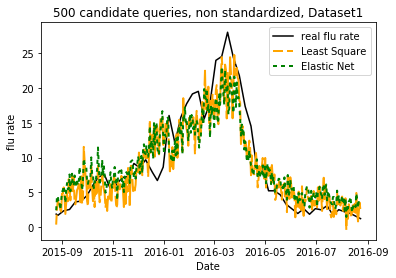

In [23]:
f= plt.figure()

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate',color='black')
#ax.plot(date[3653:4018],y_pred3,label='Ridge predicted flu rate')
ax.plot(date[3653:4018],y_pred2_ls,label='Least Square',dashes=[5,2,20,2], linewidth=2,color='orange')
ax.plot(date[3653:4018],y_pred2_en,label='Elastic Net',dashes=[2,2], linewidth=2,color='green')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=False)
plt.title("500 candidate queries, non standardized, Dataset1")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("500nostandard_test1.pdf", bbox_inches='tight')

plt.show()




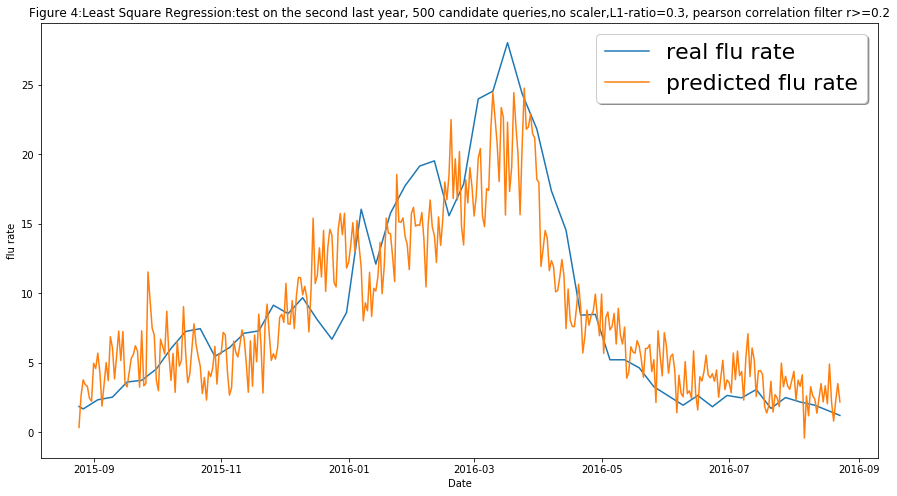

In [32]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True,prop={'size': 22})
plt.title("Figure 4:Least Square Regression:test on the second last year, 500 candidate queries,no scaler,L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()